# Rare Disease Article Views

This notebook collects rare disease Wikipedia page view data and analyzes view trends across desktop and mobile accesses from July 2015 through September 2024. 


Import libraries needed for data collection and analysis.

In [100]:
#import necessary libraries
import json, time, urllib.parse, pandas as pd
import matplotlib.pyplot as plt
import requests

### Data Collection

Read in the CSV file of [rare diseases](https://drive.google.com/file/d/15_FiKhBgXB2Ch9c0gAGYzKjF0DBhEPlY/view?usp=sharing).

In [2]:
#use pandas to read in csv file
rare_diseases = pd.read_csv('rare-disease_cleaned.AUG.2024.csv')

Use the [Wikimedia Analytics API](https://doc.wikimedia.org/generated-data-platform/aqs/analytics-api/) to get page view data. We set the start and end dates to be 07-01-2015 and 09-30-2024, respectively. We also create different parameters for the different access types (mobile-web, mobile-app, desktop).

The below API constants and function code is from [code example](https://drive.google.com/file/d/1fYTIX79t9jk-Jske8IwysV-rbRkD4_dc/view?usp=drive_link) developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024

In [39]:
### CONSTANTS ###

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<ezhang33@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is the list of Wikipedia article titles for rare diseases from the rare diseases csv file
ARTICLE_TITLES = rare_diseases['disease'].tolist()

# Set the start and end dates here for use in parameters and output file names
start_date = "2015070100" # start and end dates set to 2015-07-01 and 2024-09-30
end_date = "2024093000"

# Mobile app access params
ARTICLE_PAGEVIEWS_PARAMS_MOBILE_APP = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",   
    "agent":       "user",
    "article":     "",             
    "granularity": "monthly",
    "start":       start_date,   
    "end":         end_date
}
# Mobile web access params
ARTICLE_PAGEVIEWS_PARAMS_MOBILE_WEB = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",   
    "agent":       "user",
    "article":     "",             
    "granularity": "monthly",
    "start":       start_date,   
    "end":         end_date
}
# Desktop access params
ARTICLE_PAGEVIEWS_PARAMS_DESKTOP = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",   
    "agent":       "user",
    "article":     "",             
    "granularity": "monthly",
    "start":       start_date,   
    "end":         end_date
}

Function below is used to call the API and get view data for one article over multiple months. We leave the article title and request template blank to faciliate the different article titles and different access parameters set up in the previous cell.

In [80]:
### FUNCTIONS ###

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = None,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe = '')
    request_template['article'] = article_title_encoded
    
    # create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

Call the function in a for loop for the different access types and export to json file. For mobile access, we combine mobile-web and mobile-app access types.
The json file is formatted as a article:time series pair, where each time series is a list of dictionaries for a particular article.

In [190]:
### Mobile Access Data ###
# run function for mobile access (mobile-app and mobile-web)
mobile_views = []
for i in range(len(ARTICLE_TITLES)):
    print("Getting pageview data for: ", ARTICLE_TITLES[i])
    article_views = []
    article_dict = {}
    mobile_web_views = request_pageviews_per_article(ARTICLE_TITLES[i],request_template = ARTICLE_PAGEVIEWS_PARAMS_MOBILE_WEB)
    mobile_app_views = request_pageviews_per_article(ARTICLE_TITLES[i],request_template = ARTICLE_PAGEVIEWS_PARAMS_MOBILE_APP)
    for j in range(len(mobile_app_views['items'])):
        mobile_views_sum = {}
        if mobile_app_views['items'][j]['timestamp'] != mobile_web_views['items'][j]['timestamp']:
            print("Timestamps not aligned")
            break
        mobile_views_sum['project'] = mobile_app_views['items'][j]['project']
        mobile_views_sum['article'] = mobile_app_views['items'][j]['article']
        mobile_views_sum['granularity'] = mobile_app_views['items'][j]['granularity']
        mobile_views_sum['timestamp'] = mobile_app_views['items'][j]['timestamp']
        mobile_views_sum['agent'] = mobile_app_views['items'][j]['agent']
        mobile_views_sum['views'] = mobile_app_views['items'][j]['views'] + mobile_web_views['items'][j]['views']
        article_views.append(mobile_views_sum)
    article_dict[f'{ARTICLE_TITLES[i]}'] = article_views
    mobile_views.append(article_dict)

# save as json file 
with open(f"rare-disease_monthly_mobile_{start_date[:6]}-{end_date[:6]}.json", "w") as outfile:
    json.dump(mobile_views, outfile, indent=4)  # Write to json file
outfile.close()

Getting pageview data for:  Klinefelter syndrome
Getting pageview data for:  Aarskog–Scott syndrome
Getting pageview data for:  Abetalipoproteinemia
Getting pageview data for:  MT-TP
Getting pageview data for:  Ablepharon macrostomia syndrome
Getting pageview data for:  Acanthocheilonemiasis
Getting pageview data for:  Acanthosis nigricans
Getting pageview data for:  Aceruloplasminemia
Getting pageview data for:  Megaesophagus
Getting pageview data for:  Achard–Thiers syndrome
Getting pageview data for:  Achondrogenesis
Getting pageview data for:  Achondroplasia
Getting pageview data for:  Dwarfism
Getting pageview data for:  Osteochondrodysplasia
Getting pageview data for:  Fibroblast growth factor receptor 3
Getting pageview data for:  Vestibular schwannoma
Getting pageview data for:  Brain tumor
Getting pageview data for:  Acquired generalized lipodystrophy
Getting pageview data for:  Barraquer–Simons syndrome
Getting pageview data for:  Acrodermatitis enteropathica
Getting pageview

Getting pageview data for:  Ii antigen system
Getting pageview data for:  Cold antibody hemolytic anemia
Getting pageview data for:  Colorado tick fever
Getting pageview data for:  Common variable immunodeficiency
Getting pageview data for:  Immunodeficiency
Getting pageview data for:  Complex regional pain syndrome
Getting pageview data for:  Cone dystrophy
Getting pageview data for:  Congenital adrenal hyperplasia
Getting pageview data for:  21-Hydroxylase
Getting pageview data for:  Hyperandrogenism
Getting pageview data for:  Cell-free fetal DNA
Getting pageview data for:  Neurosexism
Getting pageview data for:  Congenital afibrinogenemia
Getting pageview data for:  Fibrinogen
Getting pageview data for:  Congenital bilateral perisylvian syndrome
Getting pageview data for:  Congenital contractural arachnodactyly
Getting pageview data for:  Gunther disease
Getting pageview data for:  Congenital fiber type disproportion
Getting pageview data for:  Congenital fibrosis of the extraocula

Getting pageview data for:  Oral pigmentation
Getting pageview data for:  Melasma
Getting pageview data for:  Corticotropic cell
Getting pageview data for:  Adenoid cystic carcinoma
Getting pageview data for:  Cylindroma
Getting pageview data for:  Adenylosuccinate lyase deficiency
Getting pageview data for:  Adie syndrome
Getting pageview data for:  Ciliary ganglion
Getting pageview data for:  Helsmoortel-Van der Aa syndrome
Getting pageview data for:  Neuronal ceroid lipofuscinosis
Getting pageview data for:  Kufs disease
Getting pageview data for:  Dracunculiasis
Getting pageview data for:  Dravet syndrome
Getting pageview data for:  Duane syndrome
Getting pageview data for:  Duane-radial ray syndrome
Getting pageview data for:  Dubin–Johnson syndrome
Getting pageview data for:  Multidrug resistance-associated protein 2
Getting pageview data for:  Bilirubin glucuronide
Getting pageview data for:  Dubowitz syndrome
Getting pageview data for:  Duchenne muscular dystrophy
Getting pagev

Getting pageview data for:  Galloway Mowat syndrome
Getting pageview data for:  Tyrosine kinase
Getting pageview data for:  Gastroparesis
Getting pageview data for:  Domperidone
Getting pageview data for:  Stomach disease
Getting pageview data for:  Granisetron
Getting pageview data for:  Metoclopramide
Getting pageview data for:  Tradipitant
Getting pageview data for:  Gastroschisis
Getting pageview data for:  Generalized arterial calcification of infancy
Getting pageview data for:  Geographic tongue
Getting pageview data for:  Gerstmann syndrome
Getting pageview data for:  Gestational trophoblastic disease
Getting pageview data for:  Gianotti–Crosti syndrome
Getting pageview data for:  Giant axonal neuropathy
Getting pageview data for:  Giant cell arteritis
Getting pageview data for:  Tocilizumab
Getting pageview data for:  Acute visual loss
Getting pageview data for:  Idiopathic giant-cell myocarditis
Getting pageview data for:  Neurocutaneous melanosis
Getting pageview data for:  G

Getting pageview data for:  Epigenetic clock
Getting pageview data for:  Inositol trisphosphate
Getting pageview data for:  Temporal dynamics of music and language
Getting pageview data for:  Memory disorder
Getting pageview data for:  Disgust
Getting pageview data for:  Gene silencing
Getting pageview data for:  Soluble NSF attachment protein
Getting pageview data for:  Glutamate receptor
Getting pageview data for:  Latrepirdine
Getting pageview data for:  Adult development
Getting pageview data for:  Folding@home
Getting pageview data for:  Clinical neurochemistry
Getting pageview data for:  Environmental enrichment
Getting pageview data for:  Procedural memory
Getting pageview data for:  Progeria
Getting pageview data for:  Lamin
Getting pageview data for:  Evolution of ageing
Getting pageview data for:  Tipifarnib
Getting pageview data for:  Hydranencephaly
Getting pageview data for:  Neural tube defect
Getting pageview data for:  Macrocephaly
Getting pageview data for:  Brain size

Getting pageview data for:  Romano–Ward syndrome
Getting pageview data for:  Oculocerebrorenal syndrome
Getting pageview data for:  Lymphangioleiomyomatosis
Getting pageview data for:  Cystic hygroma
Getting pageview data for:  Microcystic lymphatic malformation
Getting pageview data for:  Lymphangioma
Getting pageview data for:  Lymphangioma circumscriptum
Getting pageview data for:  Lymphangiomatosis
Getting pageview data for:  Lymphedema–distichiasis syndrome
Getting pageview data for:  Lymphomatoid granulomatosis
Getting pageview data for:  Diffuse large B-cell lymphoma
Getting pageview data for:  Infantile free sialic acid storage disease
Getting pageview data for:  Salla disease
Getting pageview data for:  Kifunensine
Getting pageview data for:  Machado–Joseph disease
Getting pageview data for:  Macroglossia
Getting pageview data for:  Oral and maxillofacial pathology
Getting pageview data for:  Benign symmetric lipomatosis
Getting pageview data for:  Maffucci syndrome
Getting pa

Getting pageview data for:  Hurler syndrome
Getting pageview data for:  Hunter syndrome
Getting pageview data for:  Sanfilippo syndrome
Getting pageview data for:  Sly syndrome
Getting pageview data for:  Mucormycosis
Getting pageview data for:  Zygomycosis
Getting pageview data for:  Mucous membrane pemphigoid
Getting pageview data for:  Mulibrey nanism
Getting pageview data for:  Multifocal motor neuropathy
Getting pageview data for:  Multiple endocrine neoplasia type 1
Getting pageview data for:  Multiple endocrine neoplasia type 2
Getting pageview data for:  Multiple myeloma
Getting pageview data for:  RANKL
Getting pageview data for:  Syndecan
Getting pageview data for:  Elotuzumab
Getting pageview data for:  Osteoprotegerin
Getting pageview data for:  Indatuximab ravtansine
Getting pageview data for:  Mapatumumab
Getting pageview data for:  Multiple sclerosis
Getting pageview data for:  Autoimmune disease
Getting pageview data for:  TNF inhibitor
Getting pageview data for:  Georg

Getting pageview data for:  Peeling skin syndrome
Getting pageview data for:  Pelizaeus–Merzbacher disease
Getting pageview data for:  Pendred syndrome
Getting pageview data for:  TRPV6
Getting pageview data for:  Enlarged vestibular aqueduct
Getting pageview data for:  Pentasomy X
Getting pageview data for:  Pentalogy of Cantrell
Getting pageview data for:  Chilblains
Getting pageview data for:  XX gonadal dysgenesis
Getting pageview data for:  Whooping cough
Getting pageview data for:  Peutz–Jeghers syndrome
Getting pageview data for:  Melanism
Getting pageview data for:  Pfeiffer syndrome
Getting pageview data for:  PHACE syndrome
Getting pageview data for:  22q13 deletion syndrome
Getting pageview data for:  Ring chromosome 22
Getting pageview data for:  Phenylketonuria
Getting pageview data for:  Phenylalanine
Getting pageview data for:  Nutritional genomics
Getting pageview data for:  Nutritional neuroscience
Getting pageview data for:  Pierre Robin sequence
Getting pageview data

Getting pageview data for:  Relapsing polychondritis
Getting pageview data for:  Renal agenesis
Getting pageview data for:  Renal cell carcinoma
Getting pageview data for:  Axitinib
Getting pageview data for:  TroVax
Getting pageview data for:  Anil Suri
Getting pageview data for:  Renal glycosuria
Getting pageview data for:  Renal medullary carcinoma
Getting pageview data for:  Restless legs syndrome
Getting pageview data for:  Dextropropoxyphene
Getting pageview data for:  Tactile hallucination
Getting pageview data for:  K-complex
Getting pageview data for:  Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations
Getting pageview data for:  Retinitis pigmentosa
Getting pageview data for:  Retinal degeneration (rhodopsin mutation)
Getting pageview data for:  Locus heterogeneity
Getting pageview data for:  Willie Brown (politician)
Getting pageview data for:  Cyclic nucleotide–gated ion channel
Getting pageview data for:  HK1
Getting pageview data for:  Reti

Getting pageview data for:  Tenosynovial giant cell tumor
Getting pageview data for:  Testicular cancer
Getting pageview data for:  Germ cell tumor
Getting pageview data for:  Gonocyte
Getting pageview data for:  Lucas Fitzgerald
Getting pageview data for:  Prairie Grove, Arkansas
Getting pageview data for:  Tetrahydrobiopterin deficiency
Getting pageview data for:  Tetralogy of Fallot
Getting pageview data for:  Cardiology
Getting pageview data for:  Thoracic outlet syndrome
Getting pageview data for:  Subclavian vein
Getting pageview data for:  3-M syndrome
Getting pageview data for:  TAR syndrome
Getting pageview data for:  Thrombotic thrombocytopenic purpura
Getting pageview data for:  Schistocyte
Getting pageview data for:  Microangiopathic hemolytic anemia
Getting pageview data for:  Argininosuccinic aciduria
Getting pageview data for:  Aromatic L-amino acid decarboxylase deficiency
Getting pageview data for:  Arterial tortuosity syndrome
Getting pageview data for:  Arteriovenous

Getting pageview data for:  XYY syndrome
Getting pageview data for:  Yaws
Getting pageview data for:  Yellow fever
Getting pageview data for:  Disease in colonial America
Getting pageview data for:  Brown howler
Getting pageview data for:  Stephen Girard
Getting pageview data for:  George Miller Sternberg
Getting pageview data for:  Yellow nail syndrome
Getting pageview data for:  Yunis–Varon syndrome
Getting pageview data for:  Zellweger spectrum disorders
Getting pageview data for:  Zollinger–Ellison syndrome
Getting pageview data for:  Gastrinoma
Getting pageview data for:  Atypical hemolytic uremic syndrome
Getting pageview data for:  Factor H
Getting pageview data for:  Ahus
Getting pageview data for:  Auditory neuropathy spectrum disorder
Getting pageview data for:  Auditory neuropathy
Getting pageview data for:  Autoimmune hepatitis
Getting pageview data for:  Spinocerebellar ataxia
Getting pageview data for:  Episodic ataxia
Getting pageview data for:  Autosomal dominant polycy

In [191]:
### Desktop Access Data ###
# run function for desktop access
desktop_views = []
for i in range(len(ARTICLE_TITLES)):
    print("Getting pageview data for: ", ARTICLE_TITLES[i])
    article_views = []
    article_dict = {}
    dt_views = request_pageviews_per_article(ARTICLE_TITLES[i],request_template = ARTICLE_PAGEVIEWS_PARAMS_DESKTOP)
    for j in range(len(dt_views['items'])):
        desktop_views_clean = {}
        desktop_views_clean['project'] = dt_views['items'][j]['project']
        desktop_views_clean['article'] = dt_views['items'][j]['article']
        desktop_views_clean['granularity'] = dt_views['items'][j]['granularity']
        desktop_views_clean['timestamp'] = dt_views['items'][j]['timestamp']
        desktop_views_clean['agent'] = dt_views['items'][j]['agent']
        desktop_views_clean['views'] = dt_views['items'][j]['views']
        article_views.append(desktop_views_clean)
    article_dict[f'{ARTICLE_TITLES[i]}'] = article_views
    desktop_views.append(article_dict)

# save as json file 
with open(f"rare-disease_monthly_desktop_{start_date[:6]}-{end_date[:6]}.json", "w") as outfile:
    json.dump(desktop_views, outfile, indent=4) 
outfile.close()

Getting pageview data for:  Klinefelter syndrome
Getting pageview data for:  Aarskog–Scott syndrome
Getting pageview data for:  Abetalipoproteinemia
Getting pageview data for:  MT-TP
Getting pageview data for:  Ablepharon macrostomia syndrome
Getting pageview data for:  Acanthocheilonemiasis
Getting pageview data for:  Acanthosis nigricans
Getting pageview data for:  Aceruloplasminemia
Getting pageview data for:  Megaesophagus
Getting pageview data for:  Achard–Thiers syndrome
Getting pageview data for:  Achondrogenesis
Getting pageview data for:  Achondroplasia
Getting pageview data for:  Dwarfism
Getting pageview data for:  Osteochondrodysplasia
Getting pageview data for:  Fibroblast growth factor receptor 3
Getting pageview data for:  Vestibular schwannoma
Getting pageview data for:  Brain tumor
Getting pageview data for:  Acquired generalized lipodystrophy
Getting pageview data for:  Barraquer–Simons syndrome
Getting pageview data for:  Acrodermatitis enteropathica
Getting pageview

Getting pageview data for:  Ii antigen system
Getting pageview data for:  Cold antibody hemolytic anemia
Getting pageview data for:  Colorado tick fever
Getting pageview data for:  Common variable immunodeficiency
Getting pageview data for:  Immunodeficiency
Getting pageview data for:  Complex regional pain syndrome
Getting pageview data for:  Cone dystrophy
Getting pageview data for:  Congenital adrenal hyperplasia
Getting pageview data for:  21-Hydroxylase
Getting pageview data for:  Hyperandrogenism
Getting pageview data for:  Cell-free fetal DNA
Getting pageview data for:  Neurosexism
Getting pageview data for:  Congenital afibrinogenemia
Getting pageview data for:  Fibrinogen
Getting pageview data for:  Congenital bilateral perisylvian syndrome
Getting pageview data for:  Congenital contractural arachnodactyly
Getting pageview data for:  Gunther disease
Getting pageview data for:  Congenital fiber type disproportion
Getting pageview data for:  Congenital fibrosis of the extraocula

Getting pageview data for:  Oral pigmentation
Getting pageview data for:  Melasma
Getting pageview data for:  Corticotropic cell
Getting pageview data for:  Adenoid cystic carcinoma
Getting pageview data for:  Cylindroma
Getting pageview data for:  Adenylosuccinate lyase deficiency
Getting pageview data for:  Adie syndrome
Getting pageview data for:  Ciliary ganglion
Getting pageview data for:  Helsmoortel-Van der Aa syndrome
Getting pageview data for:  Neuronal ceroid lipofuscinosis
Getting pageview data for:  Kufs disease
Getting pageview data for:  Dracunculiasis
Getting pageview data for:  Dravet syndrome
Getting pageview data for:  Duane syndrome
Getting pageview data for:  Duane-radial ray syndrome
Getting pageview data for:  Dubin–Johnson syndrome
Getting pageview data for:  Multidrug resistance-associated protein 2
Getting pageview data for:  Bilirubin glucuronide
Getting pageview data for:  Dubowitz syndrome
Getting pageview data for:  Duchenne muscular dystrophy
Getting pagev

Getting pageview data for:  Galloway Mowat syndrome
Getting pageview data for:  Tyrosine kinase
Getting pageview data for:  Gastroparesis
Getting pageview data for:  Domperidone
Getting pageview data for:  Stomach disease
Getting pageview data for:  Granisetron
Getting pageview data for:  Metoclopramide
Getting pageview data for:  Tradipitant
Getting pageview data for:  Gastroschisis
Getting pageview data for:  Generalized arterial calcification of infancy
Getting pageview data for:  Geographic tongue
Getting pageview data for:  Gerstmann syndrome
Getting pageview data for:  Gestational trophoblastic disease
Getting pageview data for:  Gianotti–Crosti syndrome
Getting pageview data for:  Giant axonal neuropathy
Getting pageview data for:  Giant cell arteritis
Getting pageview data for:  Tocilizumab
Getting pageview data for:  Acute visual loss
Getting pageview data for:  Idiopathic giant-cell myocarditis
Getting pageview data for:  Neurocutaneous melanosis
Getting pageview data for:  G

Getting pageview data for:  Epigenetic clock
Getting pageview data for:  Inositol trisphosphate
Getting pageview data for:  Temporal dynamics of music and language
Getting pageview data for:  Memory disorder
Getting pageview data for:  Disgust
Getting pageview data for:  Gene silencing
Getting pageview data for:  Soluble NSF attachment protein
Getting pageview data for:  Glutamate receptor
Getting pageview data for:  Latrepirdine
Getting pageview data for:  Adult development
Getting pageview data for:  Folding@home
Getting pageview data for:  Clinical neurochemistry
Getting pageview data for:  Environmental enrichment
Getting pageview data for:  Procedural memory
Getting pageview data for:  Progeria
Getting pageview data for:  Lamin
Getting pageview data for:  Evolution of ageing
Getting pageview data for:  Tipifarnib
Getting pageview data for:  Hydranencephaly
Getting pageview data for:  Neural tube defect
Getting pageview data for:  Macrocephaly
Getting pageview data for:  Brain size

Getting pageview data for:  Romano–Ward syndrome
Getting pageview data for:  Oculocerebrorenal syndrome
Getting pageview data for:  Lymphangioleiomyomatosis
Getting pageview data for:  Cystic hygroma
Getting pageview data for:  Microcystic lymphatic malformation
Getting pageview data for:  Lymphangioma
Getting pageview data for:  Lymphangioma circumscriptum
Getting pageview data for:  Lymphangiomatosis
Getting pageview data for:  Lymphedema–distichiasis syndrome
Getting pageview data for:  Lymphomatoid granulomatosis
Getting pageview data for:  Diffuse large B-cell lymphoma
Getting pageview data for:  Infantile free sialic acid storage disease
Getting pageview data for:  Salla disease
Getting pageview data for:  Kifunensine
Getting pageview data for:  Machado–Joseph disease
Getting pageview data for:  Macroglossia
Getting pageview data for:  Oral and maxillofacial pathology
Getting pageview data for:  Benign symmetric lipomatosis
Getting pageview data for:  Maffucci syndrome
Getting pa

Getting pageview data for:  Hurler syndrome
Getting pageview data for:  Hunter syndrome
Getting pageview data for:  Sanfilippo syndrome
Getting pageview data for:  Sly syndrome
Getting pageview data for:  Mucormycosis
Getting pageview data for:  Zygomycosis
Getting pageview data for:  Mucous membrane pemphigoid
Getting pageview data for:  Mulibrey nanism
Getting pageview data for:  Multifocal motor neuropathy
Getting pageview data for:  Multiple endocrine neoplasia type 1
Getting pageview data for:  Multiple endocrine neoplasia type 2
Getting pageview data for:  Multiple myeloma
Getting pageview data for:  RANKL
Getting pageview data for:  Syndecan
Getting pageview data for:  Elotuzumab
Getting pageview data for:  Osteoprotegerin
Getting pageview data for:  Indatuximab ravtansine
Getting pageview data for:  Mapatumumab
Getting pageview data for:  Multiple sclerosis
Getting pageview data for:  Autoimmune disease
Getting pageview data for:  TNF inhibitor
Getting pageview data for:  Georg

Getting pageview data for:  Peeling skin syndrome
Getting pageview data for:  Pelizaeus–Merzbacher disease
Getting pageview data for:  Pendred syndrome
Getting pageview data for:  TRPV6
Getting pageview data for:  Enlarged vestibular aqueduct
Getting pageview data for:  Pentasomy X
Getting pageview data for:  Pentalogy of Cantrell
Getting pageview data for:  Chilblains
Getting pageview data for:  XX gonadal dysgenesis
Getting pageview data for:  Whooping cough
Getting pageview data for:  Peutz–Jeghers syndrome
Getting pageview data for:  Melanism
Getting pageview data for:  Pfeiffer syndrome
Getting pageview data for:  PHACE syndrome
Getting pageview data for:  22q13 deletion syndrome
Getting pageview data for:  Ring chromosome 22
Getting pageview data for:  Phenylketonuria
Getting pageview data for:  Phenylalanine
Getting pageview data for:  Nutritional genomics
Getting pageview data for:  Nutritional neuroscience
Getting pageview data for:  Pierre Robin sequence
Getting pageview data

Getting pageview data for:  Relapsing polychondritis
Getting pageview data for:  Renal agenesis
Getting pageview data for:  Renal cell carcinoma
Getting pageview data for:  Axitinib
Getting pageview data for:  TroVax
Getting pageview data for:  Anil Suri
Getting pageview data for:  Renal glycosuria
Getting pageview data for:  Renal medullary carcinoma
Getting pageview data for:  Restless legs syndrome
Getting pageview data for:  Dextropropoxyphene
Getting pageview data for:  Tactile hallucination
Getting pageview data for:  K-complex
Getting pageview data for:  Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations
Getting pageview data for:  Retinitis pigmentosa
Getting pageview data for:  Retinal degeneration (rhodopsin mutation)
Getting pageview data for:  Locus heterogeneity
Getting pageview data for:  Willie Brown (politician)
Getting pageview data for:  Cyclic nucleotide–gated ion channel
Getting pageview data for:  HK1
Getting pageview data for:  Reti

Getting pageview data for:  Tenosynovial giant cell tumor
Getting pageview data for:  Testicular cancer
Getting pageview data for:  Germ cell tumor
Getting pageview data for:  Gonocyte
Getting pageview data for:  Lucas Fitzgerald
Getting pageview data for:  Prairie Grove, Arkansas
Getting pageview data for:  Tetrahydrobiopterin deficiency
Getting pageview data for:  Tetralogy of Fallot
Getting pageview data for:  Cardiology
Getting pageview data for:  Thoracic outlet syndrome
Getting pageview data for:  Subclavian vein
Getting pageview data for:  3-M syndrome
Getting pageview data for:  TAR syndrome
Getting pageview data for:  Thrombotic thrombocytopenic purpura
Getting pageview data for:  Schistocyte
Getting pageview data for:  Microangiopathic hemolytic anemia
Getting pageview data for:  Argininosuccinic aciduria
Getting pageview data for:  Aromatic L-amino acid decarboxylase deficiency
Getting pageview data for:  Arterial tortuosity syndrome
Getting pageview data for:  Arteriovenous

Getting pageview data for:  XYY syndrome
Getting pageview data for:  Yaws
Getting pageview data for:  Yellow fever
Getting pageview data for:  Disease in colonial America
Getting pageview data for:  Brown howler
Getting pageview data for:  Stephen Girard
Getting pageview data for:  George Miller Sternberg
Getting pageview data for:  Yellow nail syndrome
Getting pageview data for:  Yunis–Varon syndrome
Getting pageview data for:  Zellweger spectrum disorders
Getting pageview data for:  Zollinger–Ellison syndrome
Getting pageview data for:  Gastrinoma
Getting pageview data for:  Atypical hemolytic uremic syndrome
Getting pageview data for:  Factor H
Getting pageview data for:  Ahus
Getting pageview data for:  Auditory neuropathy spectrum disorder
Getting pageview data for:  Auditory neuropathy
Getting pageview data for:  Autoimmune hepatitis
Getting pageview data for:  Spinocerebellar ataxia
Getting pageview data for:  Episodic ataxia
Getting pageview data for:  Autosomal dominant polycy

Use the previous outputs to create a combined, cumulative access type (desktop + mobile). Output this to a json file as well.

In [227]:
### Cumulative Data ###
# combine desktop and mobile view data
cumulative_views = []
for i in range(len(desktop_views)):
    article_views = []
    article_dict = {}
    article = ARTICLE_TITLES[i]
    for j in range(len(desktop_views[i][article])):
        cumulative_views_item = {}
        cumulative_views_item['project'] = desktop_views[i][article][j]['project']
        cumulative_views_item['article'] = desktop_views[i][article][j]['article']
        cumulative_views_item['granularity'] = desktop_views[i][article][j]['granularity']
        cumulative_views_item['timestamp'] = desktop_views[i][article][j]['timestamp']
        cumulative_views_item['agent'] = desktop_views[i][article][j]['agent']
        cumulative_views_item['views'] = desktop_views[i][article][j]['views'] + mobile_views[i][article][j]['views']
        article_views.append(cumulative_views_item)
    article_dict[f'{ARTICLE_TITLES[i]}'] = article_views
    cumulative_views.append(article_dict)
    
# save as json file 
with open(f"rare-disease_monthly_cumulative_{start_date[:6]}-{end_date[:6]}.json", "w") as outfile:
    json.dump(cumulative_views, outfile, indent=4) 
outfile.close()

### Analysis

Here we start the analysis section. We are mainly interested in seeing trends over time for a select few articles.
We start by importing the previous json files and loading them as dataframes.

In [231]:
### ANALYSIS ###

# create function to change json to dataframe
def json_to_dataframe(json_file_path):
    with open(json_file_path, 'r') as json_file:
        json_data = json.load(json_file)
    data_list = []
    
    for article_dict in json_data:
        for article, records in article_dict.items():
            for record in records:
                record['article'] = article
                data_list.append(record)
    df = pd.DataFrame(data_list)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')
    return df

# make mobile dataframe
mobile_data = json_to_dataframe(f'rare-disease_monthly_mobile_{start_date[:6]}-{end_date[:6]}.json')

# make desktop dataframe
desktop_data = json_to_dataframe(f'rare-disease_monthly_desktop_{start_date[:6]}-{end_date[:6]}.json')

# make cumulative dataframe
cumulative_data = json_to_dataframe(f'rare-disease_monthly_cumulative_{start_date[:6]}-{end_date[:6]}.json')

The first graph looks at the time series trends for articles with the minimum and maximum average views for the two access types. 

We first get the articles with the min/max average view count for both mobile and desktop access types. We then filter the data on these articles and plot the 4 lines over time.

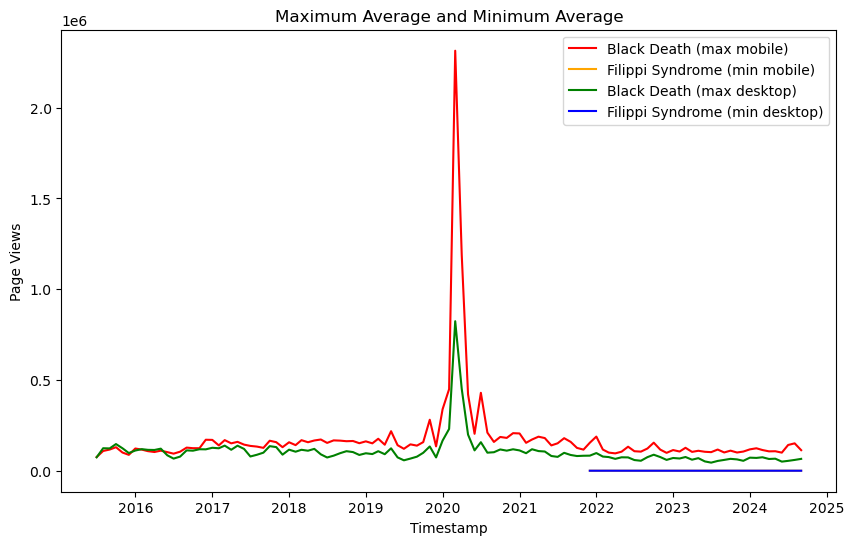

In [232]:
# graph 1 - min/max avg
# get avg
mobile_avg = mobile_data.groupby('article')['views'].mean()
desktop_avg = desktop_data.groupby('article')['views'].mean()

# sort asc
mobile_avg_sorted = mobile_avg.sort_values()
desktop_avg_sorted = desktop_avg.sort_values()

# get article titles for min/max avg values
min_mobile_article = mobile_avg_sorted.index[0]
max_mobile_article = mobile_avg_sorted.index[-1]
min_desktop_article = desktop_avg_sorted.index[0]
max_desktop_article = desktop_avg_sorted.index[-1]

# filter df on these 2 articles
min_mobile = mobile_data[mobile_data['article'] == min_mobile_article]
max_mobile = mobile_data[mobile_data['article'] == max_mobile_article]
min_desktop = desktop_data[desktop_data['article'] == min_desktop_article]
max_desktop = desktop_data[desktop_data['article'] == max_desktop_article]

# plot the data
plt.figure(figsize=(10, 6))

plt.plot(max_mobile['timestamp'], max_mobile['views'], label = f'{max_mobile_article} (max mobile)', color='red')
plt.plot(min_mobile['timestamp'], min_mobile['views'], label = f'{min_mobile_article} (min mobile)', color='orange')
plt.plot(max_desktop['timestamp'], max_desktop['views'], label = f'{max_desktop_article} (max desktop)', color='green')
plt.plot(min_desktop['timestamp'], min_desktop['views'], label = f'{min_desktop_article} (min desktop)', color='blue')

plt.title('Maximum Average and Minimum Average')
plt.xlabel('Timestamp')
plt.ylabel('Page Views')
plt.xticks()
plt.legend()

plt.show()

The second graph looks at the articles with the most views for any given month (peak) for the two access types. 

We first look for the top 10 articles by most views in a month for each of the access types. We then filter the dataframes on these articles and then plot over time.

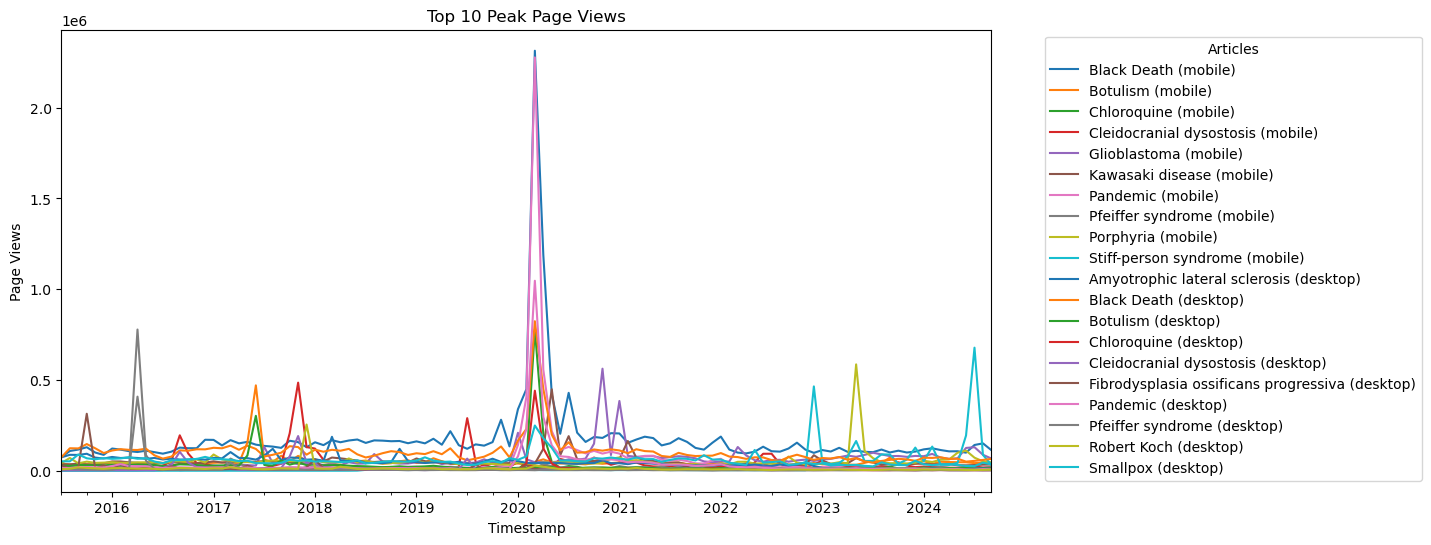

In [233]:
# graph 2 - top 10 peak for desktop/mobile
# get peak for each article
mobile_peak = mobile_data.groupby('article')['views'].max()
desktop_peak = desktop_data.groupby('article')['views'].max()

# sort desc and get top 10
mobile_peak_articles = mobile_peak.sort_values(ascending = False).index[0:10].tolist()
desktop_peak_articles = desktop_peak.sort_values(ascending = False).index[0:10].tolist()

# filter df on these articles
mobile_peak_10 = mobile_data[mobile_data['article'].isin(mobile_peak_articles)].pivot(index='timestamp', columns='article', values='views')
mobile_peak_10 = mobile_peak_10.rename(columns=lambda x: x + ' (mobile)')
desktop_peak_10 = desktop_data[desktop_data['article'].isin(desktop_peak_articles)].pivot(index='timestamp', columns='article', values='views')
desktop_peak_10 = desktop_peak_10.rename(columns=lambda x: x + ' (desktop)')

# plot the data
fig, ax = plt.subplots(figsize=(12, 6))

mobile_peak_10.plot(ax=ax, legend=False)
desktop_peak_10.plot(ax=ax)

plt.title('Top 10 Peak Page Views')
plt.xlabel('Timestamp')
plt.ylabel('Page Views')

plt.legend(title='Articles', bbox_to_anchor=(1.05, 1), loc='best')

plt.xticks()
plt.show()

The third graph looks at the trends for articles with the fewest months of data. 

We first get the 10 articles with the least amount of data for each access type, then filter the dataframes on these articles, and then plot over time.

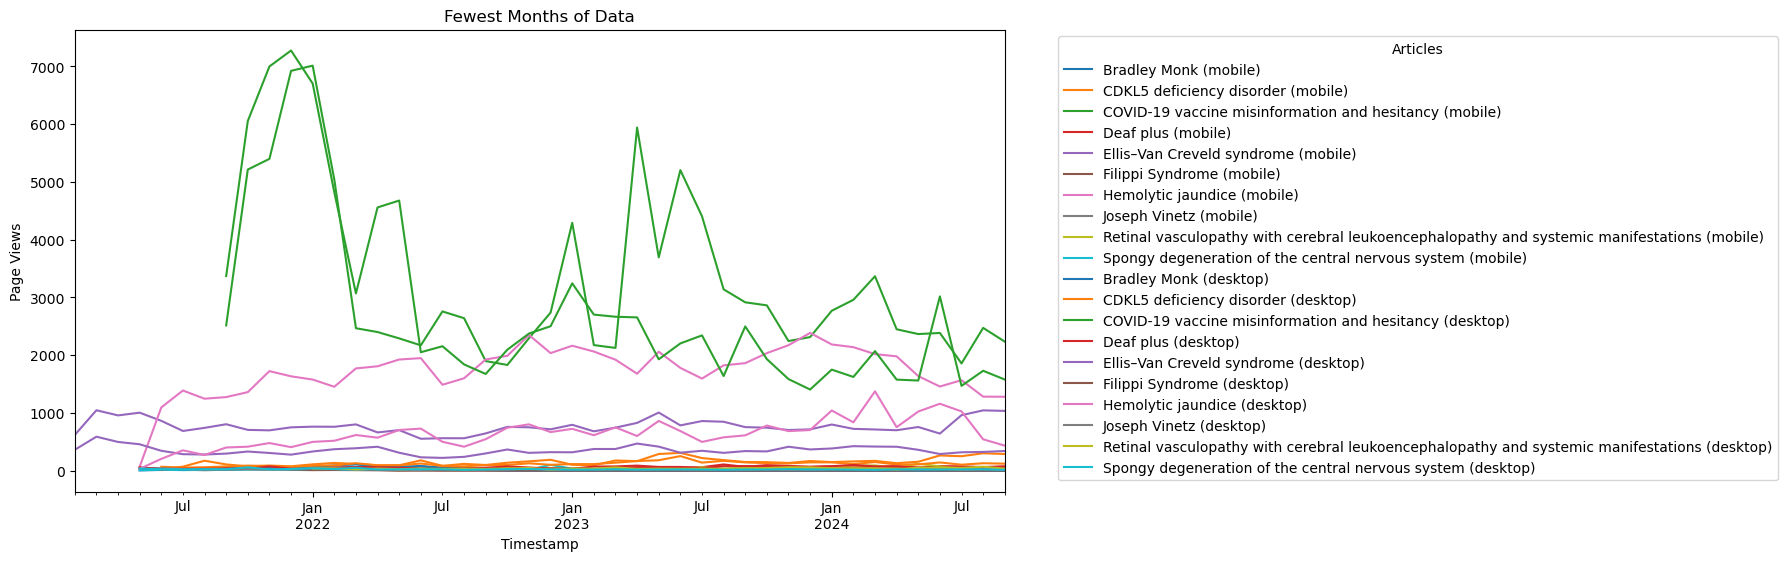

In [234]:
# graph 3 - fewest months of data
# get number of months data is available for each article
mobile_months_avail = mobile_data.groupby('article')['timestamp'].count()
desktop_months_avail = desktop_data.groupby('article')['timestamp'].count()

# sort asc and get top 10 fewest
mobile_avail_articles = mobile_months_avail.sort_values().index[0:10].tolist()
desktop_avail_articles = desktop_months_avail.sort_values().index[0:10].tolist()

# filter df on these articles
mobile_least_avail = mobile_data[mobile_data['article'].isin(mobile_avail_articles)].pivot(index='timestamp', columns='article', values='views')
mobile_least_avail = mobile_least_avail.rename(columns=lambda x: x + ' (mobile)')
desktop_least_avail = desktop_data[desktop_data['article'].isin(desktop_avail_articles)].pivot(index='timestamp', columns='article', values='views')
desktop_least_avail = desktop_least_avail.rename(columns=lambda x: x + ' (desktop)')

# plot the data
fig, ax = plt.subplots(figsize=(12, 6))

mobile_least_avail.plot(ax=ax, legend=False)
desktop_least_avail.plot(ax=ax)

plt.title('Fewest Months of Data')
plt.xlabel('Timestamp')
plt.ylabel('Page Views')

plt.legend(title='Articles', bbox_to_anchor=(1.05, 1), loc='best')

plt.xticks()
plt.show()